# Deep Learning Project - Traffic Signs Image Classification

In [1]:
import os, shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def save_hist_to_excel(filename):
    df = pd.DataFrame(history.history)
    df.to_excel(filename + '.xlsx')

## Overview of the training data

In [42]:
#setting the training directory (the training images can be found there, already sorted by class into folders)
base_training_dir = "/Users/henriquevaz/NOVA IMS/YEAR 1/SPRING SEMESTER/DL/Project/my_notebooks/Data/Training/Final_Training/Images/"
#base_training_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/"

#setting the directory where the selected training and validation images will be stored in
created_dir = "/Users/henriquevaz/NOVA IMS/YEAR 1/SPRING SEMESTER/DL/Project/my_notebooks/Data/Selected"
#created_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected"

#storing all the folder names that belong to the respective classes
all_classes = sorted(i for i in os.listdir(base_training_dir) if i.startswith("0"))

print("There are", len(all_classes), "different classes within the training data!")

There are 43 different classes within the training data!


In [43]:
#getting the number of images within each class of the training data
amount_per_class = {}

for i in range(len(all_classes)):
    directory = base_training_dir + "/" + all_classes[i]
    amount_per_class[i] = len(sorted(i for i in os.listdir(directory) if i.startswith("0")))

amount_per_class_df = pd.DataFrame.from_dict(amount_per_class, orient='index').rename(columns={0:"amount"})
amount_per_class_df.index.name = 'class'

#remove the "#" of the following line to display the number of images within each class
#amount_per_class_df

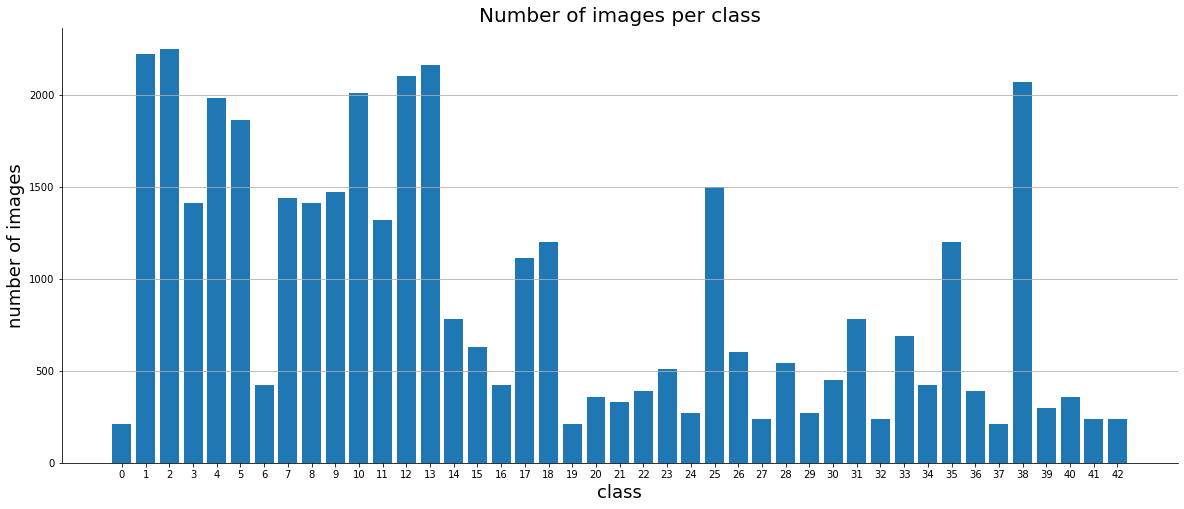

In [44]:
#displaying the number of images per class visually

plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots()
plt.bar(amount_per_class_df.index, amount_per_class_df.amount)
plt.title("Number of images per class", fontsize=20)
plt.xlabel('class', fontsize=18)
plt.ylabel('number of images', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(amount_per_class_df.index)
plt.grid(axis="y")
plt.show()

As it can be seen in the bar chart, the dataset is highly unbalanced. Some classes have over 2000 instances, while others only have 210.

In [45]:
#displaying the 20 classes with the fewest images
amount_per_class_df.sort_values("amount").head(20).T

class    0    37   19   32   27   41   42   24   29   39   21   40   20   36  \
amount  210  210  210  240  240  240  240  270  270  300  330  360  360  390   

class    22   6    16   34   30   23  
amount  390  420  420  420  450  510

Within each class, there are several groups of images, that belong together (these are basically all images of the very same traffic sign, that just differ in that they were made as a series while approaching the actual sign). These series of images shouldn't be splitted later when the data is split into training and validation sets, so some precautions might be useful:

In [46]:
#checking the size(=amount of images) of these series and whether they are all having the same size

#running a for loop over all classes
for i in range(len(all_classes)):
    directory = base_training_dir + "/" + all_classes[i]
    
    #get the names of all images within a class
    list_of_images = sorted(i for i in os.listdir(directory) if i.startswith("0"))

    image_series = []
    
    #store all the prefixes of the images (which correspond to the series they belong to)
    for element in list_of_images:
        image_series.append(element.split("_")[0])
    
    #count the frequency of each prefix, which equals the size of each respective series
    image_counts = pd.Series(image_series).value_counts().sort_index()

    for element in image_counts.values.tolist():
        if element != image_counts.values.tolist()[0]:
            #this line will show if there is a series that contains not the same number of images than the others
            print("There is a series whose number doesn't match the others in class", all_classes[i], ", with the prefix", image_counts.sort_values().index[0], "!\nIt only contains", element, "images.")
            

#apart from only one series, all others consist of exactly 30 images
print("All the other series of images contain exactly", image_counts.values.tolist()[0], "images!")

There is a series whose number doesn't match the others in class 00033 , with the prefix 00019 !
It only contains 29 images.
All the other series of images contain exactly 30 images!


## Split into training and validation datasets

As already mentioned, it is important for the split into training and validation sets that the individual image series stay together. As a first approach, there will be 210 images used per class, as this number corresponds to the amount of images in the "smallest" class. This will fix the problem of imbalance in the dataset. Subsequently, the data will be splitted by a 5:2 (150:60) ratio into training and validation set, in order to guarantee that the series will stay together.

In [3]:
new_train_dir = "/Users/henriquevaz/NOVA IMS/YEAR 1/SPRING SEMESTER/DL/Project/my_notebooks/Data/Selected/train_all"
new_val_dir = "/Users/henriquevaz/NOVA IMS/YEAR 1/SPRING SEMESTER/DL/Project/my_notebooks/Data/Selected/val_all"

#new_train_dir = "/Users/franz/Desktop/DL Project/Selected/train_all"
#new_val_dir = "/Users/franz/Desktop/DL Project/Selected/val_all"

#new_train_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected/train_all"
#new_val_dir = "/Users/philippmetzger/Documents/GitHub/Deep_Learning_Project_Group_10/Data/Selected/val_all"

In [47]:
for i in range(len(all_classes)):
    os.mkdir(new_train_dir + "/" + all_classes[i])
    os.mkdir(new_val_dir + "/" + all_classes[i])

In [48]:
import random

for i in range(len(all_classes)):
    
    list_ = os.listdir(base_training_dir + "/" + all_classes[i])
    random.shuffle(list_)
    new_list = []
    for element in list_:
        if element.startswith("000"):
            new_list.append(element)
    
    new_list = sorted(new_list)
    for image in range(len(new_list)):
        
        
        #setting the cut off according to the next closest number in steps of 30 according to a 70:30 ratio
        if len(new_list) == 210 or len(new_list) == 240:
            cut = 60
        elif len(new_list) == 270 or len(new_list) == 300 or len(new_list) == 330:
            cut = 90
        elif len(new_list) == 360 or len(new_list) == 390 or len(new_list) == 420:
            cut = 120
        elif len(new_list) == 450 or len(new_list) == 510 or len(new_list) == 540:
            cut = 150
        elif len(new_list) == 600 or len(new_list) == 630:
            cut = 180
        elif len(new_list) == 689:
            cut = 210 - 1
        elif len(new_list) == 780:
            cut = 240
        elif len(new_list) == 1110:
            cut = 330
        elif len(new_list) == 1200:
            cut = 360
        elif len(new_list) == 1320:
            cut = 390
        elif len(new_list) == 1410 or len(new_list) == 1440:
            cut = 420
        elif len(new_list) == 1470 or len(new_list) == 1500:
            cut = 450
        elif len(new_list) == 1860:
            cut = 570
        elif len(new_list) == 1980 or len(new_list) == 2010:
            cut = 600
        elif len(new_list) == 2070 or len(new_list) == 2100:
            cut = 630
        elif len(new_list) == 2160 or len(new_list) == 2220:
            cut = 660
        elif len(new_list) == 2250:
            cut = 690
         
        
        if image < len(new_list) - cut:
            
            src = base_training_dir + "/" + all_classes[i] + "/" + new_list[image]
            dst = new_train_dir + "/" + all_classes[i] + "/"  + new_list[image]
            shutil.copyfile(src, dst)
            
        else:
            src = base_training_dir + "/" + all_classes[i] + "/" + new_list[image]
            dst = new_val_dir + "/" + all_classes[i] + "/"  + new_list[image]
            shutil.copyfile(src, dst)

In [49]:
size_per_class_list = []

for i in range(len(all_classes)):
    size_per_class_list.append([len(os.listdir(new_train_dir + "/" + all_classes[i])), len(os.listdir(new_val_dir + "/" + all_classes[i]))])
    print("Class", i, ": training set size =", len(os.listdir(new_train_dir + "/" + all_classes[i])), "; validation set size:", len(os.listdir(new_val_dir + "/" + all_classes[i])))

Class 0 : training set size = 150 ; validation set size: 60
Class 1 : training set size = 1560 ; validation set size: 660
Class 2 : training set size = 1560 ; validation set size: 690
Class 3 : training set size = 990 ; validation set size: 420
Class 4 : training set size = 1380 ; validation set size: 600
Class 5 : training set size = 1290 ; validation set size: 570
Class 6 : training set size = 300 ; validation set size: 120
Class 7 : training set size = 1020 ; validation set size: 420
Class 8 : training set size = 990 ; validation set size: 420
Class 9 : training set size = 1020 ; validation set size: 450
Class 10 : training set size = 1410 ; validation set size: 600
Class 11 : training set size = 930 ; validation set size: 390
Class 12 : training set size = 1470 ; validation set size: 630
Class 13 : training set size = 1500 ; validation set size: 660
Class 14 : training set size = 540 ; validation set size: 240
Class 15 : training set size = 450 ; validation set size: 180
Class 16 :

Now, there should be exactly 150 images within the train folder of each class and 60 images within the validation folder. Having 43 different classes, this means that there are a total of 6,450 (150x43) training images and another 2,580 (60x43) validation images. A sanity check will show if this worked correctly:

As it can be seen, it worked correctly!

## Data Preprocessing

After running the upper part once, the notebook can be started from here from now on:

In [50]:
#this cell is optional and the notebook should be runned from here once the upper part has been executed once

import os, shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from PIL import Image
import numpy as np

In [51]:
train_dir = new_train_dir
validation_dir = new_val_dir

##### Normalization

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #target_size=(100,100),
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical",
    color_mode="grayscale"
    )


validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    #target_size=(100,100),
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical",
    color_mode="grayscale"
    )

Found 27450 images belonging to 43 classes.
Found 11759 images belonging to 43 classes.


In [53]:
x_train=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
x_val=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])

In [54]:
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

train_datagen.fit(x_train)
test_datagen.fit(x_val)

##### Re-Creating the generators with the normalized image data

In [55]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    #target_size=(100,100),
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical",
    color_mode="grayscale"
    )



validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    #target_size=(100,100),
    target_size=(150,150),
    batch_size=20,
    class_mode="categorical",
    color_mode="grayscale"
    )

Found 27450 images belonging to 43 classes.
Found 11759 images belonging to 43 classes.


In [56]:
sys.modules['Image'] = Image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 1)
labels batch shape: (20, 43)


## Draft of the model

### Base model (Using the 'Down' Version)

In [57]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
#model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(100, 100, 1)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Dropout(0.15))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2) ))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense (43, activation='softmax'))

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 149, 149, 32)      160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 33, 33, 128)      

In [59]:
from tensorflow.keras import optimizers

#compilation
model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [60]:
# 1-5
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    )

Epoch 1/5
1373/1373 [==============================] - 216s 157ms/step - loss: 536.6936 - acc: 0.2429 - val_loss: 5139.1440 - val_acc: 0.6895
Epoch 2/5
1373/1373 [==============================] - 215s 157ms/step - loss: 77639.1737 - acc: 0.4519 - val_loss: 144841.7188 - val_acc: 0.7042
Epoch 3/5
1373/1373 [==============================] - 215s 156ms/step - loss: 582106.4947 - acc: 0.5504 - val_loss: 812835.0625 - val_acc: 0.7308
Epoch 4/5
1373/1373 [==============================] - 221s 161ms/step - loss: 2547601.7615 - acc: 0.5646 - val_loss: 1442844.8750 - val_acc: 0.7939
Epoch 5/5
1373/1373 [==============================] - 216s 157ms/step - loss: 6978588.6379 - acc: 0.5957 - val_loss: 5839011.0000 - val_acc: 0.7584


In [61]:
# 6-10
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    )

Epoch 1/5
1373/1373 [==============================] - 216s 157ms/step - loss: 24584656.0000 - acc: 0.5668 - val_loss: 12885381.0000 - val_acc: 0.7601
Epoch 2/5
1373/1373 [==============================] - 216s 157ms/step - loss: 40963060.0000 - acc: 0.5933 - val_loss: 17184852.0000 - val_acc: 0.8065
Epoch 3/5
1373/1373 [==============================] - 216s 158ms/step - loss: 58346692.0000 - acc: 0.6273 - val_loss: 30029168.0000 - val_acc: 0.7829
Epoch 4/5
1373/1373 [==============================] - 216s 157ms/step - loss: 73473800.0000 - acc: 0.6613 - val_loss: 47958952.0000 - val_acc: 0.7937
Epoch 5/5
1373/1373 [==============================] - 217s 158ms/step - loss: 96090656.0000 - acc: 0.6785 - val_loss: 54573576.0000 - val_acc: 0.8077


In [62]:
# 11-15
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    )

Epoch 1/5
1373/1373 [==============================] - 216s 158ms/step - loss: 124773304.0000 - acc: 0.6888 - val_loss: 83293632.0000 - val_acc: 0.8016
Epoch 2/5
1373/1373 [==============================] - 217s 158ms/step - loss: 152767808.0000 - acc: 0.7046 - val_loss: 99552920.0000 - val_acc: 0.8027
Epoch 3/5
1373/1373 [==============================] - 216s 158ms/step - loss: 173674944.0000 - acc: 0.7209 - val_loss: 110281264.0000 - val_acc: 0.8361
Epoch 4/5
1373/1373 [==============================] - 215s 157ms/step - loss: 185998288.0000 - acc: 0.7391 - val_loss: 131039840.0000 - val_acc: 0.8212
Epoch 5/5
1373/1373 [==============================] - 215s 156ms/step - loss: 186018192.0000 - acc: 0.7603 - val_loss: 163000576.0000 - val_acc: 0.8399


In [63]:
# 16-20
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    )

Epoch 1/5
1373/1373 [==============================] - 215s 156ms/step - loss: 196299216.0000 - acc: 0.7741 - val_loss: 161574528.0000 - val_acc: 0.8450
Epoch 2/5
1373/1373 [==============================] - 216s 157ms/step - loss: 209700400.0000 - acc: 0.7852 - val_loss: 196352320.0000 - val_acc: 0.8454
Epoch 3/5
1373/1373 [==============================] - 217s 158ms/step - loss: 223761280.0000 - acc: 0.7909 - val_loss: 252626512.0000 - val_acc: 0.8282
Epoch 4/5
1373/1373 [==============================] - 217s 158ms/step - loss: 256819664.0000 - acc: 0.7888 - val_loss: 249167840.0000 - val_acc: 0.8434
Epoch 5/5
1373/1373 [==============================] - 215s 157ms/step - loss: 263620720.0000 - acc: 0.8016 - val_loss: 287371968.0000 - val_acc: 0.8355


In [64]:
# 21-25
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    )

Epoch 1/5
1373/1373 [==============================] - 215s 157ms/step - loss: 285514496.0000 - acc: 0.7995 - val_loss: 330322048.0000 - val_acc: 0.8525
Epoch 2/5
1373/1373 [==============================] - 215s 157ms/step - loss: 335231808.0000 - acc: 0.7965 - val_loss: 361119776.0000 - val_acc: 0.8371
Epoch 3/5
1373/1373 [==============================] - 215s 157ms/step - loss: 349668224.0000 - acc: 0.8007 - val_loss: 401825696.0000 - val_acc: 0.8466
Epoch 4/5
1373/1373 [==============================] - 215s 157ms/step - loss: 389495584.0000 - acc: 0.7958 - val_loss: 426500192.0000 - val_acc: 0.8582
Epoch 5/5
1373/1373 [==============================] - 215s 157ms/step - loss: 419530176.0000 - acc: 0.7984 - val_loss: 429860576.0000 - val_acc: 0.8531


In [65]:
# 26-40
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    )

Epoch 1/15
1373/1373 [==============================] - 217s 158ms/step - loss: 443923616.0000 - acc: 0.8042 - val_loss: 469569600.0000 - val_acc: 0.8532
Epoch 2/15
1373/1373 [==============================] - 224s 163ms/step - loss: 456614592.0000 - acc: 0.8059 - val_loss: 558118080.0000 - val_acc: 0.8501
Epoch 3/15
1373/1373 [==============================] - 232s 169ms/step - loss: 433647712.0000 - acc: 0.8180 - val_loss: 647899200.0000 - val_acc: 0.8292
Epoch 4/15
1373/1373 [==============================] - 229s 167ms/step - loss: 419466208.0000 - acc: 0.8257 - val_loss: 589558784.0000 - val_acc: 0.8458
Epoch 5/15
1373/1373 [==============================] - 218s 159ms/step - loss: 398158912.0000 - acc: 0.8334 - val_loss: 649756416.0000 - val_acc: 0.8457
Epoch 6/15
1373/1373 [==============================] - 216s 158ms/step - loss: 459035072.0000 - acc: 0.8267 - val_loss: 746620864.0000 - val_acc: 0.8300
Epoch 7/15
1373/1373 [==============================] - 217s 158ms/step - lo

In [66]:
# 26-40
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    )

Epoch 1/10
1373/1373 [==============================] - 215s 157ms/step - loss: 458871328.0000 - acc: 0.8537 - val_loss: 933200704.0000 - val_acc: 0.8703
Epoch 2/10
1373/1373 [==============================] - 216s 157ms/step - loss: 426981728.0000 - acc: 0.8561 - val_loss: 1027965632.0000 - val_acc: 0.8303
Epoch 3/10
1373/1373 [==============================] - 219s 159ms/step - loss: 443017248.0000 - acc: 0.8554 - val_loss: 925058112.0000 - val_acc: 0.8681
Epoch 4/10
1373/1373 [==============================] - 219s 159ms/step - loss: 452266560.0000 - acc: 0.8571 - val_loss: 982299840.0000 - val_acc: 0.8535
Epoch 5/10
1373/1373 [==============================] - 215s 156ms/step - loss: 448400544.0000 - acc: 0.8617 - val_loss: 1069839104.0000 - val_acc: 0.8569
Epoch 6/10
1373/1373 [==============================] - 215s 156ms/step - loss: 427931424.0000 - acc: 0.8617 - val_loss: 1023234432.0000 - val_acc: 0.8697
Epoch 7/10
1373/1373 [==============================] - 215s 157ms/step -

In [36]:
model.save('model_all_data_Down_Normalization_150_150_25_epochs')

INFO:tensorflow:Assets written to: model_all_data_Down_Normalization_150_150_25_epochs/assets


In [ ]:
save_hist_to_excel('history_all_data_Down_Normalization_150_150_25_epochs_HenriqueTest')

In [ ]:
#Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()